# ESP: Estimating Spectra from Photometry

## What is it?

ESP is a python package designed to estimate galaxy spectra only from their photometric colors. It requires a training set of spectra for a Principal Component Analysis that will produce a set of eigenspectra and coefficients that can reproduce the original spectra. These coefficients are then used to train a Gaussian Process for each coefficient where the input to each Gaussian Process are the colors of the training spectra. Therefore, when feeding the Gaussian Processes the colors of a new galaxy, they return a set of PCA coefficients that can be used to build a new estimated spectrum for the new galaxy.

## Getting started

Setup ESP according to the [README](https://github.com/jbkalmbach/ESP/blob/master/README.md) in the main folder of the repository.

## Use PCA to create a basis set.

Here we are going to take a set of sample spectra and run the PCA. All this requires is a library of spectra. We have added an example set of spectra from the LSST [sims_sed_library](https://lsst-web.ncsa.illinois.edu/sim-data/sed_library/seds_170124.tar.gz).

In [1]:
import esp
import numpy as np
import matplotlib.pyplot as plt
import os
from esp.lsst_utils import BandpassDict
%load_ext autoreload
%autoreload 2

### Load the spectra and perform PCA

In [2]:
example_data_dir = '../data/example_data/' # Example spectral library
pca_obj = esp.pcaSED() # Initialize the pcaSED object
pca_obj.load_full_spectra(example_data_dir) # Load the spectra
pca_obj.PCA(comps=10) # Calculate using all components

Done loading spectra from file


### Visualize the Eigenspectra

We will use ESP's plotting utilities to plot the eigenspectra in the visual wavelengths.

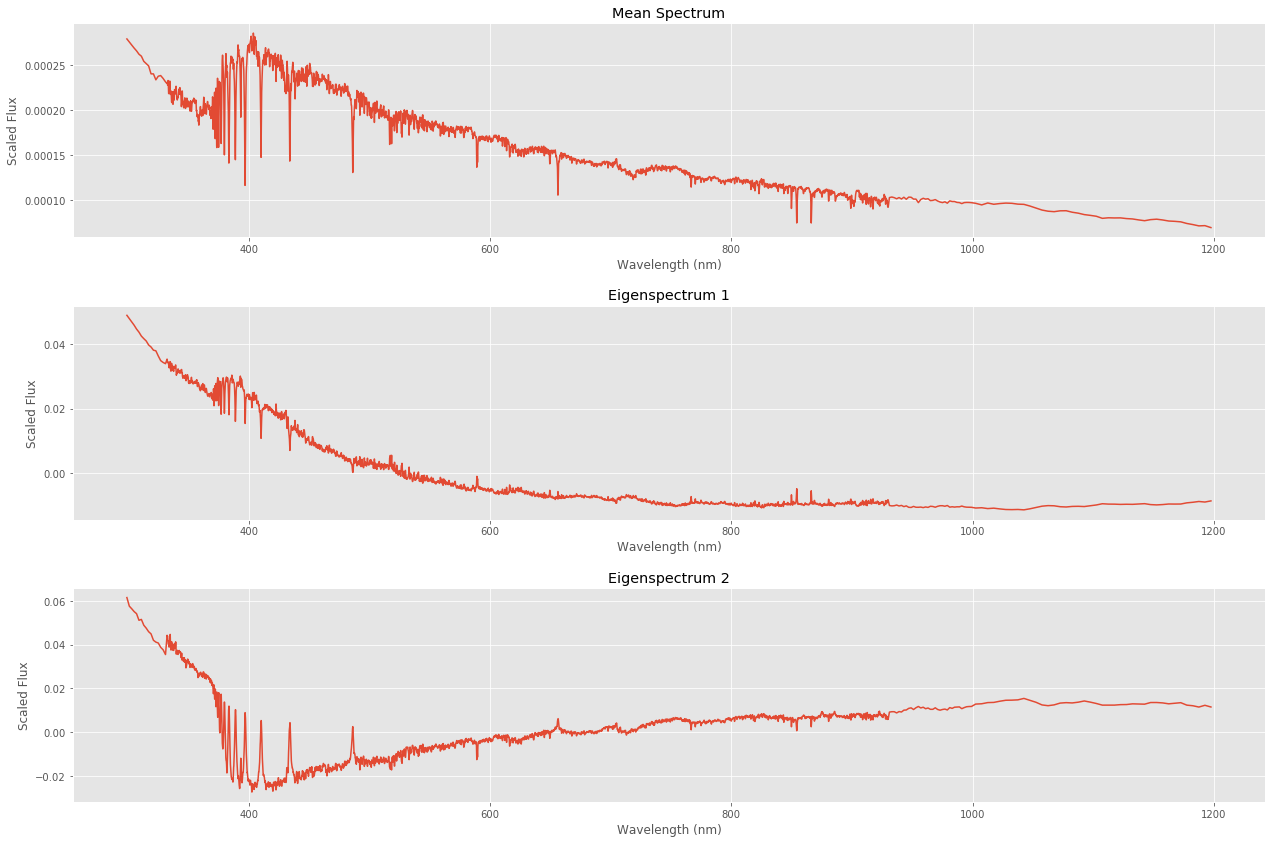

In [3]:
plotter = esp.plotUtils()
fig = plotter.plot_eigenspectra(pca_obj, 2)
fig

### Save PCA results

In [4]:
os.mkdir('results')
pca_obj.write_output('results')

## Estimation of Spectra from Photometry

This is what this software exists to do. Now that you have a set of basis spectra you can create an ESP estimation object and give it the colors from a photometric catalog. Then you can use it to estimate spectra for the objects in your catalog.

### Load PCA results from file in a new `pcaSED` object

This is what you would do if you were running an analysis on a previously saved set of eigenspectra and coefficients.

In [5]:
new_pca_obj = esp.pcaSED()
new_pca_obj.load_pca_output('results')

### Create a sample catalog

Let's start by randomly varying the colors from our original spectra library to create a sample set of colors for which we want to estimate spectra.

We can use the new `pcaSED` object to calculate the colors of the spectra that compose the training data for our estimation methods. We start by loading up a set of LSST bandpasses into a `BandpassDict`. We have saved a version from the LSST simulations team in the data folder of the repository, but these are also provided by the LSST simulation team [here](https://github.com/lsst/throughputs/tree/master/baseline).

In [6]:
bandpass_dir = '../data/lsst_bandpasses/'
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

Then we can call `calc_colors` to calculate the training set colors.

In [7]:
colors = new_pca_obj.calc_colors(bandpass_dict, 10)
print colors[0:3]

[[ 1.4929158   0.59936636  0.29770002  0.1690767   0.19888057]
 [ 1.24226315  0.52636294  0.24677608  0.10527891  0.07863345]
 [ 0.42452407 -0.00708825  0.01245164  0.02283399  0.02162798]]


And finally we create a new sample set of colors by adding random gaussian offsets to the original colors.

In [8]:
np.random.seed(42)
sample_cat_colors = colors + np.random.normal(0.0, 0.2, size=50).reshape((10, 5))

### Nearest Neighbor Estimation

Included in ESP is a simple nearest neighbor interpolation to compare against the Gaussian Process results. It uses `scikit-learn`'s k-nearest neighbor methods with a user specified k value.

Note that we also require a `BandpassDict` object here. We can reuse the one we created above.

In [9]:
nn_obj = esp.nearestNeighborEstimate(new_pca_obj, bandpass_dict, sample_cat_colors)

In [10]:
nn_spec = nn_obj.nn_predict(1)

In [11]:
nn_colors = nn_spec.calc_colors(bandpass_dict, 10)
print nn_colors

[[ 1.4929158   0.59936636  0.29770002  0.1690767   0.19888057]
 [ 1.24226315  0.52636294  0.24677608  0.10527891  0.07863345]
 [ 0.08565165 -0.22354494 -0.16804298 -0.09086358 -0.11219682]
 [ 0.42452407 -0.00708825  0.01245164  0.02283399  0.02162798]
 [ 2.07584574  0.87645962  0.50592775  0.27701911  0.28281606]
 [-0.27524941 -0.38768019 -0.28494435 -0.23936991 -0.21146007]
 [ 0.88854517  0.21089487  0.1067944   0.04039486  0.00634465]
 [ 1.4929158   0.59936636  0.29770002  0.1690767   0.19888057]
 [ 0.08565165 -0.22354494 -0.16804298 -0.09086358 -0.11219682]
 [ 0.4589896  -0.07862281  0.09024506  0.08877091  0.07480225]]


The `nearestNeighborEstimate` object can also take the arguments for the `scikit-learn` methods using the `knr_args` with a dictionary specifying the desired settings. For instance, we show how to change the weighting from uniform to distance dependent.

In [12]:
nn_spec = nn_obj.nn_predict(5, knr_args=dict(weights='distance'))

In [13]:
nn_colors = nn_spec.calc_colors(bandpass_dict, 10)
print nn_colors

[[ 1.44948234  0.62230859  0.33708666  0.18897176  0.19992778]
 [ 1.35087751  0.57335027  0.30710314  0.16766825  0.17430908]
 [ 0.23428443 -0.10451996 -0.0307044  -0.00499442 -0.01104218]
 [ 0.4302046  -0.0128338   0.02452903  0.0244875   0.00810127]
 [ 1.55177473  0.68197451  0.38436909  0.21636447  0.22626174]
 [ 0.0112906  -0.20954585 -0.11263455 -0.06697265 -0.05862302]
 [ 0.68901602  0.1696596   0.11687911  0.05959773  0.03705137]
 [ 1.40754883  0.60232254  0.32613501  0.18150403  0.1911944 ]
 [ 0.18323596 -0.13150027 -0.05408104 -0.01974857 -0.02437069]
 [ 0.43460892 -0.0136621   0.02830687  0.02773224  0.01155962]]


### Gaussian Process Estimation

The best results using ESP should be obtained using Gaussian Processes to estimate the PCA coefficients that can be used to construct estimated spectra from colors. The `gaussianProcessEstimate` method does this for you. Once again you give the estimator the `pcaSED` object containing the eigenspectra and training coefficients, the `BandpassDict` for calculating colors and the colors for the objects for which you want to estimate spectra.

In [14]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bandpass_dict, sample_cat_colors)

The next step is to define the initial kernel function for the Gaussian Processes that estimate the PCA coefficients. Right now you can specify an exponential kernel using 'exp' or a squared exponential kernel using 'sq_exp'. The next two numbers are a scaling value that normalizes the variance between objects and a length parameter that defines the length scale on the kernel. If you are familiar with george and want to define your own more complicated kernel you can do that as well.

In [15]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3)

We then use the kernel to predict PCA coefficients that will create an estimated spectra based upon the input colors of the catalog objects. The Gaussian Process for each set of PCA coefficients uses `George`'s optimization method to optimize the hyperparameters in the kernel.

In [16]:
gp_spec = gp_obj.gp_predict(gp_kernel)

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


Finally, we can evaluate the colors the estimate spectrum give back as a way to measure how well our spectrum can reproduce the input data.

In [17]:
gp_colors = gp_spec.calc_colors(bandpass_dict, 10)
print gp_colors

[[  1.48259565e+00   6.34273717e-01   3.51637041e-01   1.97321028e-01
    2.06638566e-01]
 [  1.20720703e+00   5.24873542e-01   3.04177878e-01   1.73014997e-01
    1.81074863e-01]
 [  2.23148027e-01  -8.10239054e-02  -2.72291043e-02  -1.44996039e-02
   -2.40196438e-02]
 [  3.16087419e-01  -4.57000039e-02  -6.75145850e-03  -3.33506373e-03
   -2.06629463e-02]
 [  1.92674918e+00   7.88706699e-01   4.17094266e-01   2.30498389e-01
    2.40935565e-01]
 [ -1.87715688e-01  -3.62335147e-01  -2.51756701e-01  -1.73704523e-01
   -1.44281105e-01]
 [  7.67671808e-01   2.62621809e-01   1.82086524e-01   1.09516237e-01
    1.09411657e-01]
 [  1.32756032e+00   5.86262668e-01   3.34829134e-01   1.89706629e-01
    1.99054981e-01]
 [  1.19639924e-01  -1.58376044e-01  -8.73754682e-02  -5.52563335e-02
   -6.74647498e-02]
 [  3.25796145e-01  -4.18719758e-02  -4.04103510e-04   2.33542088e-03
   -1.36647545e-02]]


The `gp_spec` is a new `pcaSED` object that contains the coefficients that define the estimated spectra for each catalog object as well as the other information from the input `pcaSED` object that you need construct the spectra. Since it is a `pcaSED` object it means you can also just call `reconstruct_spectra` to produce the estimated spectra from the coefficients.

In [18]:
gp_spec.coeffs

array([[ -5.29392211e-03,   3.97502760e-04,  -5.97803844e-05,
          5.96910317e-07,   1.24569224e-09,  -5.29031044e-18,
          8.35792815e-27,  -1.54863411e-27,   4.43354059e-28,
          2.30928677e-63],
       [ -4.03598243e-03,   3.87658390e-05,  -1.04272225e-04,
         -5.26424343e-08,  -2.43779358e-12,   1.31558089e-17,
         -5.13274147e-29,   5.61151679e-32,   2.62751572e-30,
          3.29888947e-65],
       [  4.39784968e-03,  -1.25272081e-04,   5.18402542e-06,
          1.73387747e-06,  -1.06190594e-13,   4.35922786e-23,
         -2.17210606e-37,  -9.39048947e-37,  -2.25057184e-37,
          6.40151736e-73],
       [  3.64618000e-03,  -5.37071792e-04,   2.38330581e-05,
          9.62796067e-07,   3.14543529e-11,  -5.09440836e-19,
          5.71694290e-31,   4.06877332e-30,   8.49295963e-34,
         -2.11298331e-67],
       [ -6.79193645e-03,   1.07672793e-03,   6.55271114e-05,
          3.56056066e-07,  -7.07914054e-11,   1.51207927e-19,
          4.91073749e-32

In [19]:
gp_spec.reconstruct_spectra(10)

array([[  4.48352090e-05,   4.52598350e-05,   4.71502913e-05, ...,
          1.21002058e-04,   1.22372724e-04,   1.18107400e-04],
       [  8.45857994e-05,   8.49526678e-05,   8.59582976e-05, ...,
          1.04685496e-04,   1.05444673e-04,   1.01982254e-04],
       [  4.87095267e-04,   4.79709153e-04,   4.71544985e-04, ...,
          3.07910763e-05,   3.02259189e-05,   2.96785954e-05],
       ..., 
       [  6.64109050e-05,   6.66839038e-05,   6.80662174e-05, ...,
          1.14709706e-04,   1.15902935e-04,   1.11920220e-04],
       [  5.65995756e-04,   5.56072606e-04,   5.46200066e-04, ...,
          2.37984266e-05,   2.32903612e-05,   2.29166694e-05],
       [  4.18165055e-04,   4.13550829e-04,   4.06782713e-04, ...,
          3.40956785e-05,   3.34186501e-05,   3.28448311e-05]])

Finally, the `gp_spec` object also contains the hyperparameter settings for each set of PCA coefficients for further analysis.

In [20]:
np.exp(gp_spec.params)

array([[  6.46474508e-05,   1.00654859e+02],
       [  2.46361195e-06,   1.58661503e+00],
       [  2.03176438e-07,   3.22550082e-02],
       [  2.47913142e-08,   8.46513490e-03],
       [  7.90147130e-09,   8.84631510e-04],
       [  3.75381235e-09,   1.63991239e-04],
       [  2.43902383e-09,   4.73493594e-05],
       [  8.03498342e-10,   4.73493514e-05],
       [  1.88471192e-10,   4.73493506e-05],
       [  9.79633677e-48,   4.73493506e-05]])